# First I need to fetch weather data

In [1]:
import requests
from meteostat import Stations, Daily
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from bs4 import BeautifulSoup
import yfinance as yf
import time
import seaborn as sns

## Here is data using OpenWeatherMap. The problem here is that it doesn't allow me to fetch past weather data!! Only current and forecasting data

## I have therefore installed meteostat which a free python library containing free data, given stationpoints around the world

#### First I need a way to find the name of the city and get the Latitude and longitude data for that city
#### There is some data that I am missing. The prices are moving together but I feel there are some other regions I am missing. Looking online I saw that Columbia which is Geographically close to Brazil is also a major coffee producers

I downloaded the data for Colombia from the same website

I downloaded the data from: https://simplemaps.com/data/br-cities


In [388]:
br_cities = pd.read_csv('./br.csv')
co_cities = pd.read_csv('./co.csv')
#Now I have cities where I have regions in Brazil and Colombia
cities = pd.concat([br_cities,co_cities])

In [390]:
cities.tail()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
79,Leticia,-4.2167,-69.9333,Colombia,CO,Amazonas,admin,33503.0,32450.0
80,La Virginia,4.9167,-75.8333,Colombia,CO,Risaralda,minor,32330.0,32330.0
81,Mitú,1.1983,-70.1733,Colombia,CO,Vaupés,admin,28382.0,28382.0
82,Inírida,3.8653,-67.9239,Colombia,CO,Guainía,admin,20279.0,19816.0
83,Puerto Carreño,6.1903,-67.4836,Colombia,CO,Vichada,admin,16763.0,16763.0


## Brazil's coffee production
#### Since Brazil is a big country I want to narrow down where the production actually happens
According to USDA report on Table 2: https://apps.fas.usda.gov/newgainapi/api/Report/DownloadReportByFileName?fileName=Coffee%20Semi-annual_Brasilia_Brazil_BR2023-0031

We have access to states where most of the coffee farming happens. These states are:
- Mina Gerias with 33.1 Million kg bags in 2023
- Sao Paulo with 5.6 Million kg bags in 2023
- Espitito Santo (mostly Rubusta)

**Another big producer of Coffee in the same region is Colombia, I would love to have some data for Columbia as well.**
Regions with coffe production in Columbia also called the Coffee triable

- Antioquia
- Huila
- Tolima 

**With that knowledge I will close down on weather data for the cities in those regions!**



In [392]:
admin = cities['admin_name'].value_counts()
admin.head(10)

admin_name
São Paulo              23
Bahia                  19
Maranhão               12
Ceará                  11
Antioquia              11
Cundinamarca           10
Pernambuco              9
Minas Gerais            9
Rio Grande do Norte     8
Rio Grande do Sul       7
Name: count, dtype: int64

In [883]:
regions = ['Minas Gerais','São Paulo','Bahia','Antioquia','Hulia']
#,'Tolima'
#city = cities[cities['admin_name']=='Minas Gerais']
city = cities[cities['admin_name'].isin(regions)]
city.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,São Paulo,-23.5500,-46.6333,Brazil,BR,São Paulo,admin,23086000.0,12252023.0
2,Belo Horizonte,-19.9167,-43.9333,Brazil,BR,Minas Gerais,admin,5328000.0,2502557.0
5,Salvador,-12.9747,-38.4767,Brazil,BR,Bahia,admin,2418005.0,2418005.0
7,Santos,-23.9369,-46.3250,Brazil,BR,São Paulo,NaN,1897551.0,418608.0
12,Guarulhos,-23.4628,-46.5328,Brazil,BR,São Paulo,NaN,1324781.0,1324781.0


### Here I am downloading the average tempratures and precipitation data for the regions in Brazil where we have most of the coffee produciton. 

I have daily weather data starting from **2019** unitl end of **2023** from the closest stations where data is available in these regions/citites. 

In [884]:
start = datetime(2021, 5, 1)
end = datetime(2024, 3, 31)
#empty dataframe
wdata = pd.DataFrame()
ix = 0

for i in city['city']:
    #The servers used are free but we don't want them to be overloaded with data collection and the code to crash. So I have put a timer between entries!
    time.sleep(0.1)
    name = i
    #Getting latitude and longitude values for each cities in our dataset
    lat = city.loc[city['city'] == i, 'lat'].values[0]
    lng = city.loc[city['city'] == i, 'lng'].values[0]

    #Calling the station
    stations = Stations()
    #Plugging in the lat and lon values for the city
    stations = stations.nearby(lat, lng)
    station = stations.fetch(1)  # Fetch closest station

    # Fetch daily historical data for the specified station and time period
    name = Daily(station, start, end)
    name = name.fetch()
    # Select only the columns for temperature and precipitation
    name = name[['tavg','prcp']]
    #Putting time index as a column so we can merge easily
    name.reset_index(inplace=True)
    #Renaming the columns so we have a better idea which column has the data for which city
    name = name.rename(columns={'tavg':f'tavg_{i}'})
    name = name.rename(columns={'prcp':f'prcp_{i}'})
    #wdata is ann empty dataset. The first time I want it to take the values of the first city, and then after merge new cities into it
    if ix == 0:
        wdata = name.copy()
        ix +=1
    else:
        wdata = wdata.merge(name,right_on='time',left_on='time',how='left')

wdata = wdata.drop_duplicates(subset='time')
# So when we divide the data later both have the dates

### Saving a copy of the file, just in case the servers aren't functionning

In [ ]:
wdata = wdata.set_index('time')
wdata.to_csv('weather.csv', index=False)

#### I want the data to be divided between precepitaion data and average temprature data

In [ ]:
prcp_columns = [col for col in wdata.columns if col.startswith('prcp')]
# Create a new DataFrame with these columns
prcp_df = wdata[prcp_columns]
prcp_df['Average prcp'] = prcp_df.mean(axis=1, skipna=True)
prcp_df.reset_index(inplace=True)

tavg_columns = [col for col in wdata.columns if col.startswith('tavg')]
# Create a new DataFrame with these columns
tavg_df = wdata[tavg_columns]
tavg_df['Average Temperature'] = tavg_df.mean(axis=1, skipna=True)

ext = tavg_df[tavg_df['Average Temperature']>= 24.5]



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
tavg_df.head()

,tavg_Belo Horizonte,tavg_Salvador,tavg_Contagem,tavg_Ribeirão das Neves,tavg_Lauro de Freitas,tavg_Ibirité,tavg_Valença,tavg_Serrinha,tavg_Senhor do Bonfim,tavg_Campo Formoso,...,tavg_Itagüí,tavg_Envigado,tavg_Turbo,tavg_Rionegro,tavg_Apartadó,tavg_Sabanalarga,tavg_Sabaneta,tavg_Copacabana,tavg_La Estrella,Average Temperature
time,,,,,,,,,,,,,,,,,,,,,
2021-05-01,18.5,25.9,18.7,19.0,26.4,16.0,23.5,23.2,NaN,NaN,...,18.0,18.0,24.9,14.5,24.9,18.0,18.0,18.0,18.0,21.060606
2021-05-02,18.3,25.1,18.6,18.5,26.9,16.3,23.8,22.1,NaN,NaN,...,18.3,18.3,28.3,15.4,28.3,18.3,18.3,18.3,18.3,21.257576
2021-05-03,20.0,24.7,19.5,19.8,25.9,16.9,24.1,22.3,NaN,NaN,...,17.8,17.8,26.2,14.4,26.2,17.8,17.8,17.8,17.8,21.169697
2021-05-04,20.8,24.8,19.8,20.0,25.1,17.8,23.5,21.8,NaN,NaN,...,18.3,18.3,25.3,15.7,25.3,18.3,18.3,18.3,18.3,21.254545
2021-05-05,21.2,24.6,21.4,20.4,25.4,18.9,24.0,23.1,NaN,NaN,...,18.6,18.6,29.5,15.9,29.5,18.6,18.6,18.6,18.6,21.851515


In [ ]:
ext.head(2)

,tavg_Belo Horizonte,tavg_Salvador,tavg_Contagem,tavg_Ribeirão das Neves,tavg_Lauro de Freitas,tavg_Ibirité,tavg_Valença,tavg_Serrinha,tavg_Senhor do Bonfim,tavg_Campo Formoso,...,tavg_Itagüí,tavg_Envigado,tavg_Turbo,tavg_Rionegro,tavg_Apartadó,tavg_Sabanalarga,tavg_Sabaneta,tavg_Copacabana,tavg_La Estrella,Average Temperature
time,,,,,,,,,,,,,,,,,,,,,
2021-09-18,24.4,24.7,24.6,24.3,25.3,21.9,24.9,23.2,NaN,NaN,...,26.2,26.2,27.6,17.8,27.6,26.2,26.2,26.2,26.2,24.584848
2021-10-01,25.9,26.4,25.8,26.8,26.4,22.9,26.1,26.2,NaN,NaN,...,21.8,21.8,27.3,16.3,27.3,21.8,21.8,21.8,21.8,24.857576


# Temprature Data

The plot bellow shows the average temrature changes accross cities and time. We can clearly see that the tempratures across this region is quite similar. We don't have major outliers where the temprature of one city is much higher or lower then the average. 
We have a total average of around **22.3°C**

Further more we can see that the temprature has a **V** shape, where in summer the tempratures are high and in winter they are quite low. In general however, the tempratures are quite stable in this region. 

If we want to look at the average temprature for all the citis across time in figure 2 we see much clearly the **V** shape we are talking about.

The average tempratures across cities are much more stable, where we see a low of around **16°C** and a high of **24°C**

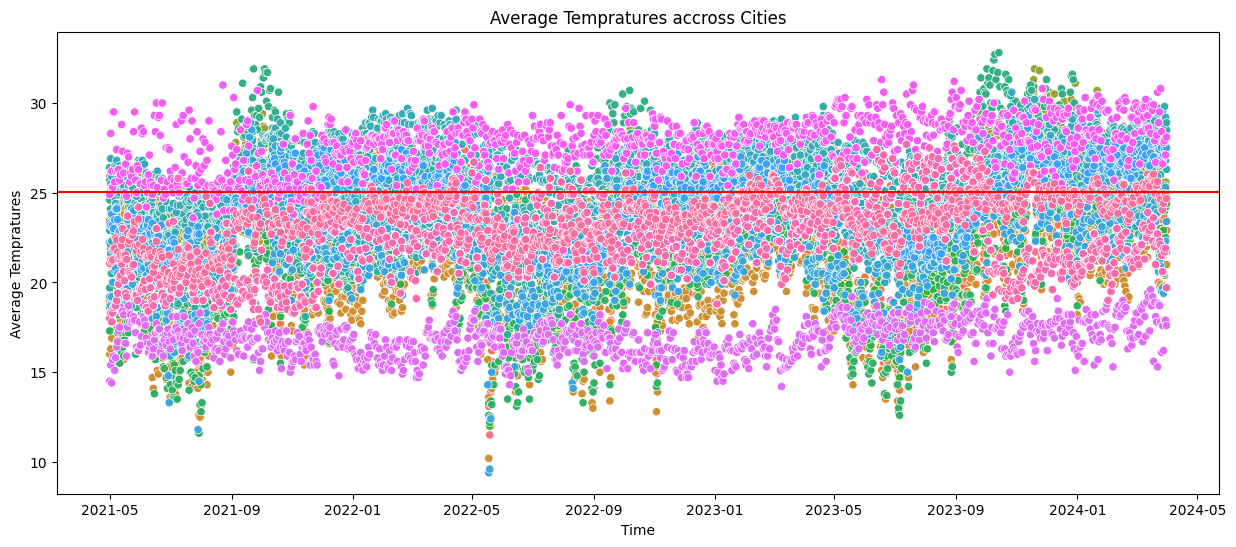

In [ ]:
# Computing the temprature mean across cities and time.
average_temp = ext['Average Temperature'].mean()

#This changes the DataFrame from a wide format to a long format where each 
#row represents a single observation, making it easier to plot using functions that expect data in this format.
df_melted = tavg_df.reset_index().melt(id_vars='time', var_name='variable', value_name='value')

# Create a plot using Seaborn
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_melted, x='time', y='value', hue='variable',legend=False)


# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Average Tempratures')
plt.title('Average Tempratures accross Cities')
plt.axhline(y = average_temp,color='red')

# Show the plot
plt.show()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


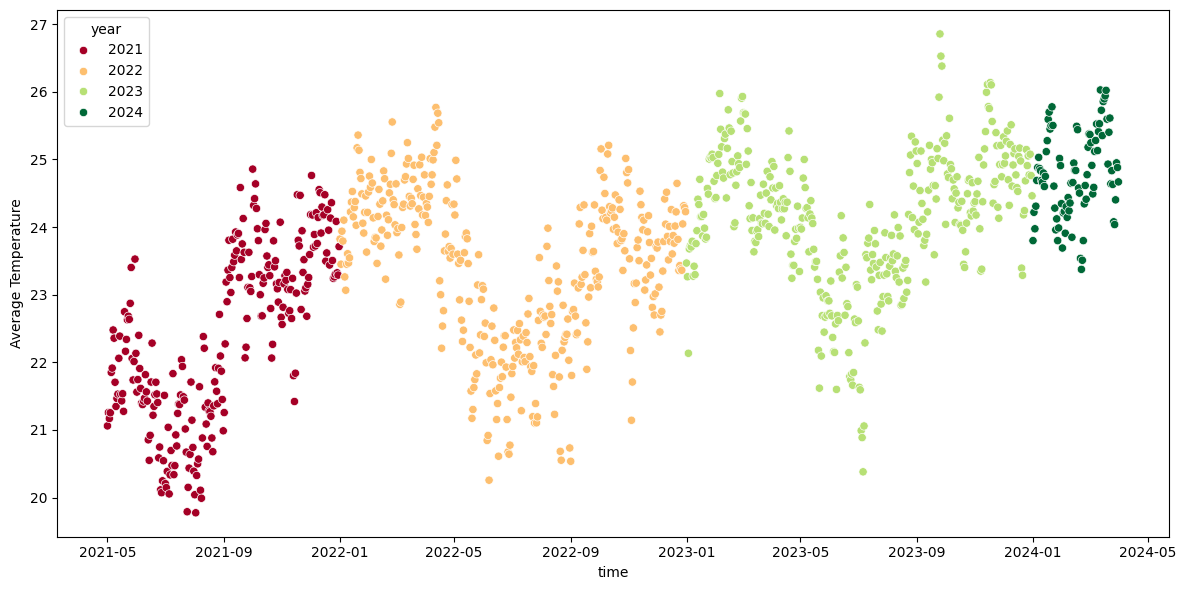

In [ ]:
tavg_df.reset_index(inplace=True)
tavg_df['year'] = tavg_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=tavg_df, x='time', y='Average Temperature',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


# Precipitation Data

Here we see that for before 2021, we have very little data, most of it is set at zero or the data doesn't even exists. Further more we have huge outliers, where we have precipitation of 40 to 50 mm, for years before 2021 which does seem a bit odd. 

I believe this is because of data issue, and that the server might have errors for precipitation data before 2021.

I will there for cut to years after 2021, to see how the data looks

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


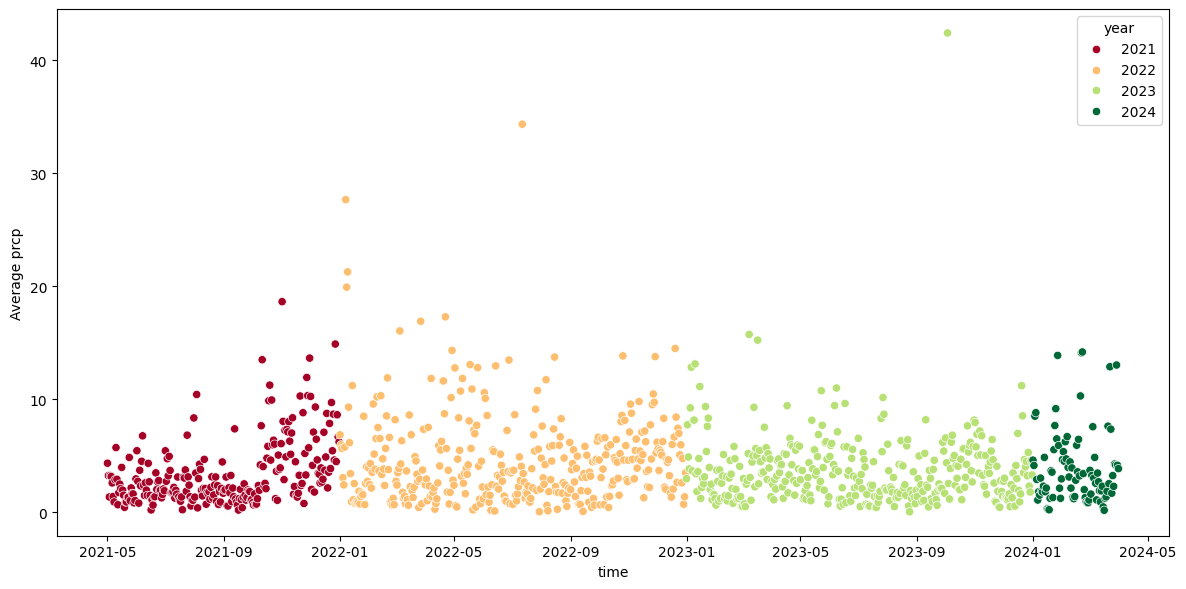

In [ ]:
prcp_df['year'] = prcp_df['time'].dt.year  # Extracting year from date
fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=prcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='RdYlGn')

# Adjust layout
plt.tight_layout()
plt.show()


Now that we look at the precipitation data for year **2021** onwards, we can see a **U** shapes. There is very little precipitation in the summer but in winter seasen there are a lot of rainfall, especially in year 2022, with high precipitation

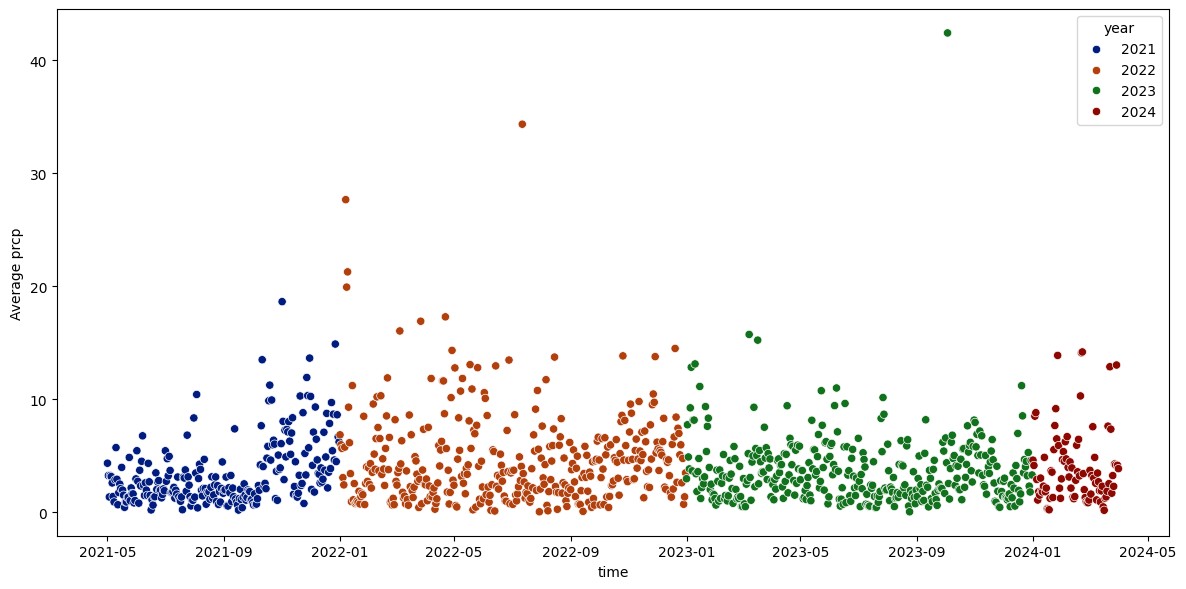

In [ ]:
newprcp_df = prcp_df[prcp_df['year']>=2021]

fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=newprcp_df, x='time', y='Average prcp',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()


#### Coffee Prices specifically Arabica, the coffee beans that is produced in Brazil

I want the data for the same time periodes as the weather data available to me

**Note that these are worldwide coffee prices of *Arabica* and not just Brazil's.** As we have seen before Brazil's produces 40% of world's coffee beans so it must have 

In [ ]:
arabica = "KC=F"

price = yf.download(arabica,start,end)
price.reset_index(inplace=True)


price['AVG_Price'] = (price['High'] + price['Low']) / 2
price = price[['Date','AVG_Price','Volume']]


[*********************100%%**********************]  1 of 1 completed


In [ ]:
price['return'] = price['AVG_Price'].pct_change()*100
price['cum_return'] = price['return'].cumsum()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
price.head()

,Date,AVG_Price,Volume,return,cum_return
0,2021-05-03,139.600006,18,NaN,NaN
1,2021-05-04,139.175003,13,-0.304443,-0.304443
2,2021-05-05,143.174995,2,2.874074,2.569630
3,2021-05-06,149.250000,3,4.243063,6.812693
4,2021-05-07,151.474998,3,1.490786,8.303479


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


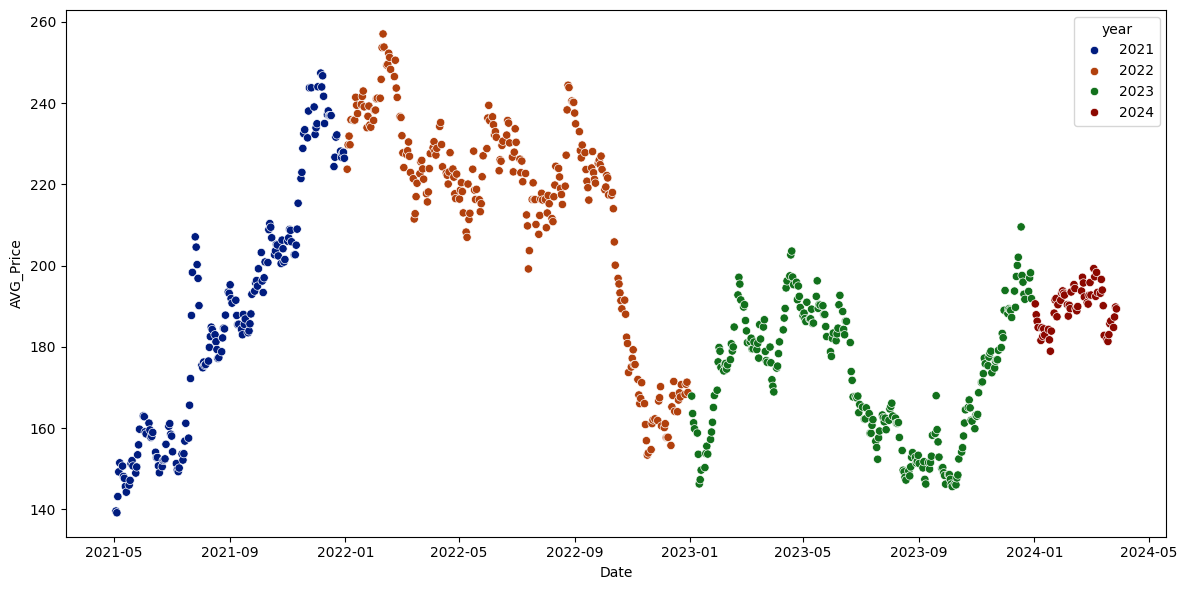

In [ ]:
price['year'] = price['Date'].dt.year  # Extracting year from date

fig, axs = plt.subplots(figsize=(12, 6))


sns.scatterplot(data=price, x='Date', y='AVG_Price',hue='year', ax=axs,palette='dark')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
main = pd.merge(tavg_df,prcp_df,right_on='time',left_on='time',how ='inner')
main = main.merge(price, right_on='Date',left_on='time',how ='inner')
main = main.drop_duplicates(subset='time')

In [ ]:
main.describe()

,time,tavg_Belo Horizonte,tavg_Salvador,tavg_Contagem,tavg_Ribeirão das Neves,tavg_Lauro de Freitas,tavg_Ibirité,tavg_Valença,tavg_Serrinha,tavg_Senhor do Bonfim,...,prcp_Copacabana,prcp_La Estrella,Average prcp,year_y,Date,AVG_Price,Volume,return,cum_return,year
count,733,733.000000,733.000000,733.000000,733.000000,733.000000,731.000000,725.000000,731.000000,0.0,...,582.000000,582.000000,733.000000,733.000000,733,733.000000,733.000000,732.000000,732.000000,733.000000
mean,2022-10-14 06:11:17.762619392,22.066439,25.810641,21.677626,22.124284,26.823192,19.321341,25.506897,24.428044,NaN,...,5.730928,5.730928,3.941320,2022.276944,2022-10-14 06:11:17.762619392,191.975989,12342.407913,0.059309,37.566856,2022.276944
min,2021-05-03 00:00:00,11.500000,21.500000,12.000000,12.500000,22.600000,9.500000,21.500000,18.500000,NaN,...,0.000000,0.000000,0.030000,2021.000000,2021-05-03 00:00:00,139.175003,0.000000,-7.729721,-0.304443,2021.000000
25%,2022-01-21 00:00:00,20.300000,24.600000,19.900000,20.200000,25.800000,17.700000,24.500000,22.500000,NaN,...,0.000000,0.000000,1.540000,2022.000000,2022-01-21 00:00:00,167.450005,24.000000,-1.161870,26.660639,2022.000000
50%,2022-10-13 00:00:00,22.200000,25.900000,21.900000,22.400000,26.800000,19.400000,25.700000,24.700000,NaN,...,2.000000,2.000000,2.990000,2022.000000,2022-10-13 00:00:00,189.300003,12766.000000,0.000000,39.372078,2022.000000
75%,2023-07-10 00:00:00,24.200000,27.000000,23.700000,24.400000,28.000000,21.100000,26.500000,26.200000,NaN,...,8.775000,8.775000,5.096667,2023.000000,2023-07-10 00:00:00,218.150002,21361.000000,1.220927,49.980253,2023.000000
max,2024-03-28 00:00:00,30.800000,29.300000,30.100000,30.700000,30.100000,28.400000,28.000000,29.000000,NaN,...,152.100000,152.100000,42.413333,2024.000000,2024-03-28 00:00:00,257.050003,49900.000000,9.014372,64.678312,2024.000000
std,NaN,2.760399,1.537881,2.658617,2.905226,1.426508,2.576593,1.297333,2.200914,NaN,...,9.623873,9.623873,3.706030,0.911958,NaN,28.801974,11671.196676,1.881652,14.393876,0.911958


In [ ]:
main.head()

main.set_index('Date', inplace=True)

main['lagged_price'] = main['AVG_Price'].shift(30)
main = main.dropna(subset='lagged_price')



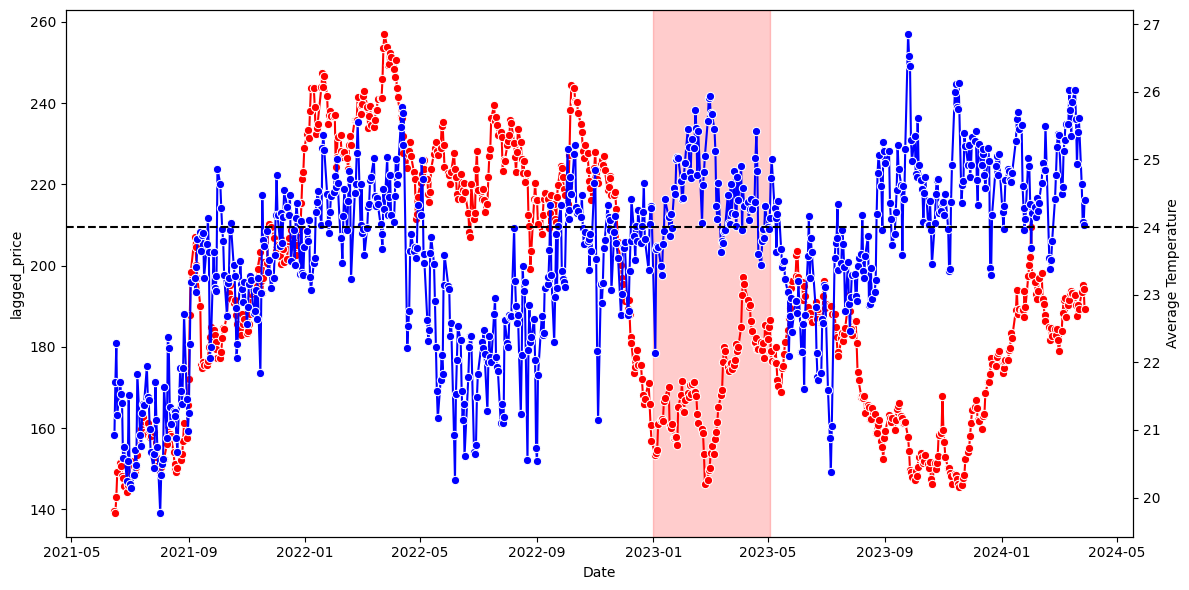

In [ ]:

fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='lagged_price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

axs.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)

axs2.axhline(y=24,color='black',linestyle='--')

# Adjust layout
plt.tight_layout()
plt.show()

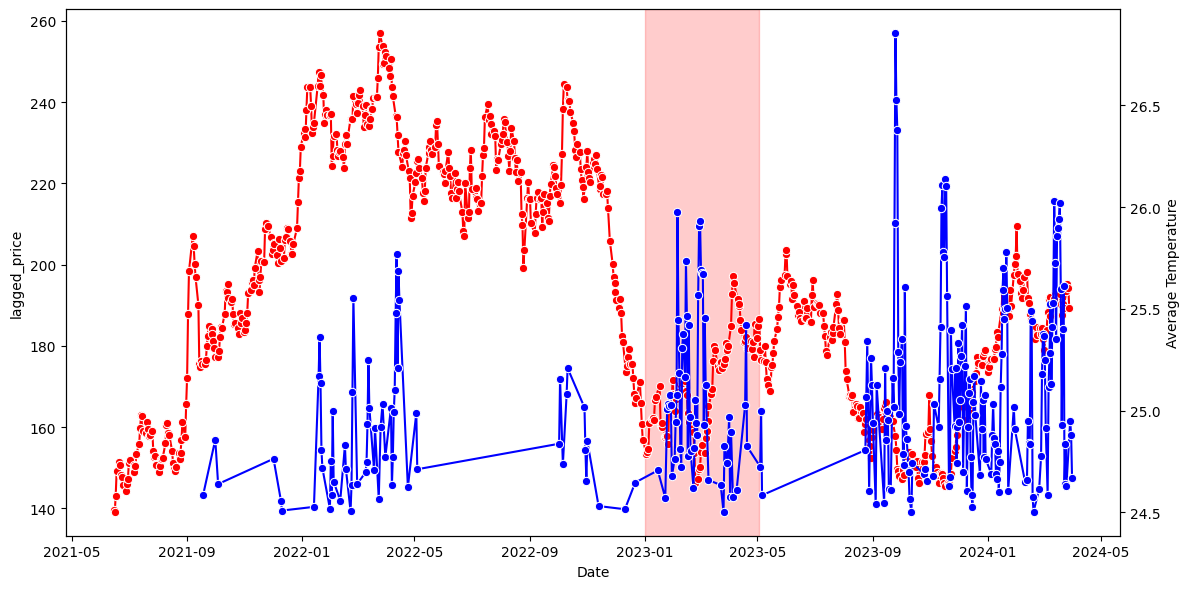

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))

sns.lineplot(data=main, x='Date', y='lagged_price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=ext, x='time', y='Average Temperature', ax=axs2, color='blue',marker='o')

axs.axvspan(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-05-03'), color='red', alpha=0.2)
# Adjust layout
plt.tight_layout()
plt.show()


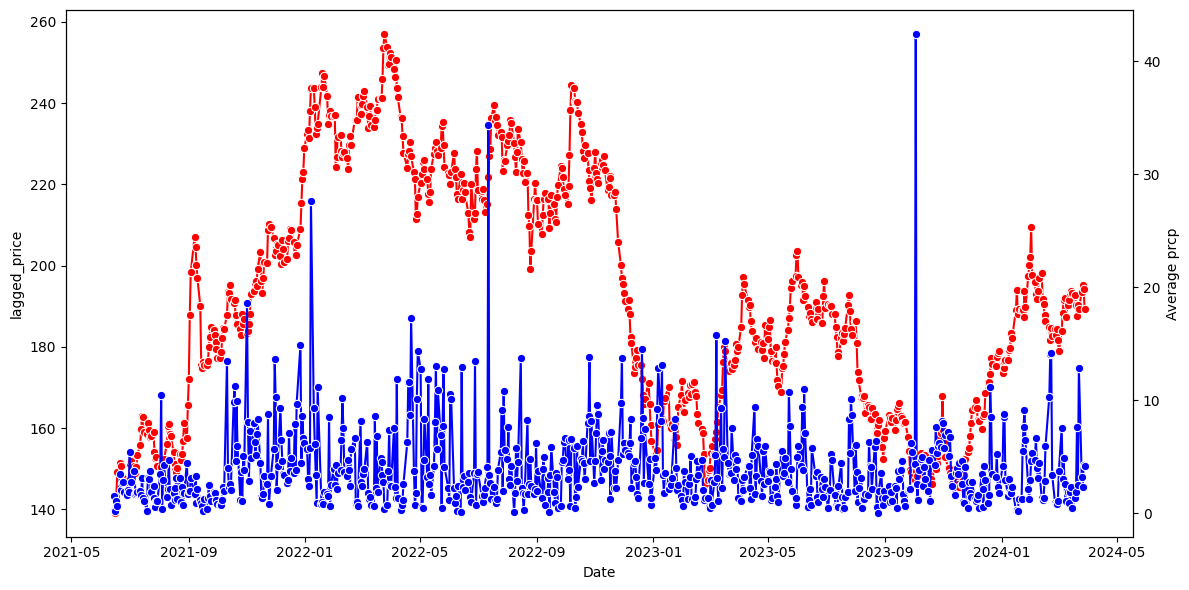

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))


sns.lineplot(data=main, x='Date', y='lagged_price', ax=axs,color='red',marker='o')
axs2 = axs.twinx()
sns.lineplot(data=main, x='time', y='Average prcp', ax=axs2, color='blue',marker='o')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
main.head(2)

,time,tavg_Belo Horizonte,tavg_Salvador,tavg_Contagem,tavg_Ribeirão das Neves,tavg_Lauro de Freitas,tavg_Ibirité,tavg_Valença,tavg_Serrinha,tavg_Senhor do Bonfim,...,prcp_Copacabana,prcp_La Estrella,Average prcp,year_y,AVG_Price,Volume,return,cum_return,year,lagged_price
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-15,2021-06-15,18.1,23.8,17.7,17.3,24.9,15.7,24.1,21.8,NaN,...,NaN,NaN,1.482353,2021,152.750000,19013,-0.859974,9.427700,2021,139.600006
2021-06-16,2021-06-16,19.3,24.0,19.2,18.7,25.3,17.4,24.0,21.6,NaN,...,NaN,NaN,0.194118,2021,152.800003,11288,0.032735,9.460435,2021,139.175003


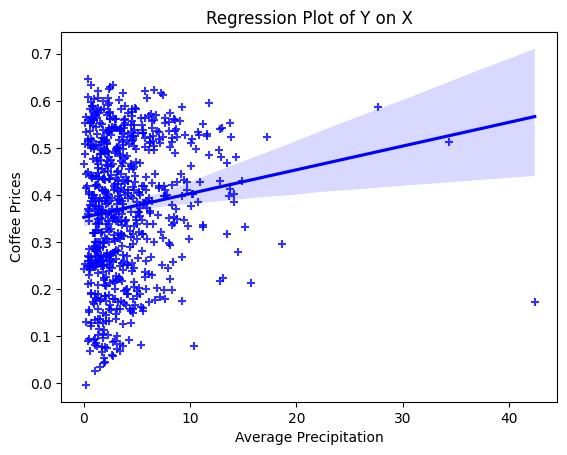

In [ ]:
main['lag_return'] = main['lagged_price'].pct_change()
main['cum_lag_return'] = main['lag_return'].cumsum()

sns.regplot(x='Average prcp', y='cum_lag_return', data=main, color='blue', marker='+')

# Set labels and title
plt.xlabel('Average Precipitation')
plt.ylabel('Coffee Prices')
plt.title('Regression Plot of Y on X')

# Display the plot
plt.show()

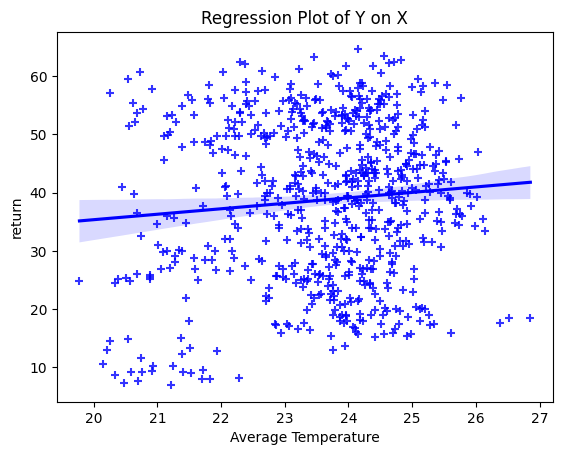

In [ ]:

main['Extereme'] = ext['Average Temperature']

sns.regplot(x='Average Temperature', y='cum_return', data=main, color='blue', marker='+')

# Set labels and title
plt.xlabel('Average Temperature')
plt.ylabel('return')
plt.title('Regression Plot of Y on X')

# Display the plot
plt.show()

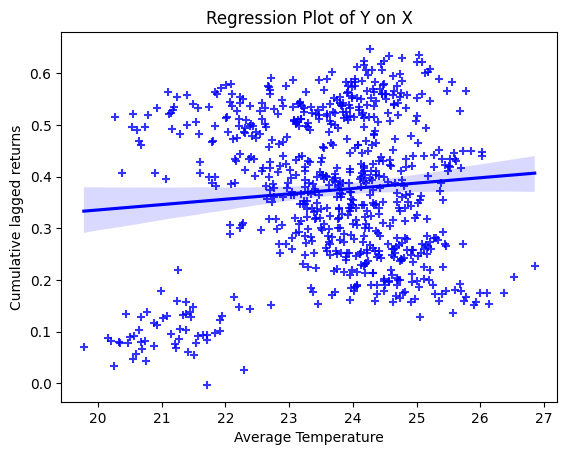

In [ ]:
sns.regplot(x='Average Temperature', y='cum_lag_return', data=main, color='blue', marker='+')

# Set labels and title
plt.xlabel('Average Temperature')
plt.ylabel('Cumulative lagged returns')
plt.title('Regression Plot of Y on X')

# Display the plot
plt.show()

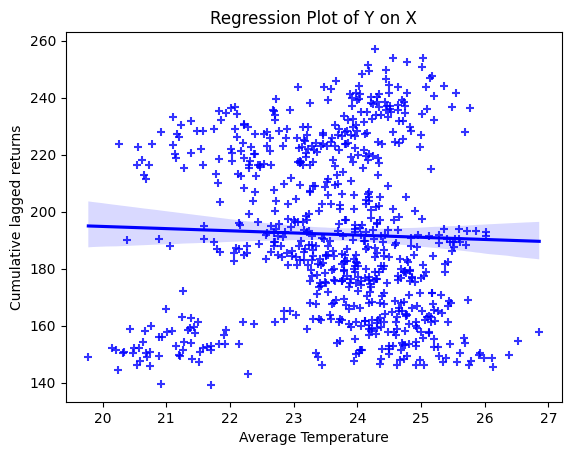

In [ ]:
sns.regplot(x='Average Temperature', y='lagged_price', data=main, color='blue', marker='+')

# Set labels and title
plt.xlabel('Average Temperature')
plt.ylabel('Cumulative lagged returns')
plt.title('Regression Plot of Y on X')

# Display the plot
plt.show()

In [ ]:
main.head()
main = main.dropna(subset=['Average Temperature','cum_lag_return','return'])

In [ ]:
# Adding a constant to the model (for the intercept)
#X = main['Average Temperature']

X = sm.add_constant(main['Average Temperature'])  # Independent variable
Y = main['cum_lag_return']  # Dependent variable

# Alternatively, you can add a constant using the assign method: 
# df = df.assign(constant=1)

# Create the OLS model
model = sm.OLS(Y, X)

# Fit the model
results = model.fit()

# Print the regression results
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:         cum_lag_return   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.011
Date:                Tue, 23 Apr 2024   Prob (F-statistic):             0.0145
Time:                        14:23:13   Log-Likelihood:                 356.89
No. Observations:                 702   AIC:                            -709.8
Df Residuals:                     700   BIC:                            -700.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1277    